In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
# Чтение датасета нормы из файла, зарегистрированного кинект
test_df = pd.read_csv("test_data.txt", sep='\t', comment='#', encoding='utf-8')
# Сдвиг значений из индекса на колонку вперед
test_df = test_df.shift(periods=1, axis="columns")
test_df['HumFlex-L'] = test_df.index
test_df.index=[_ for _ in range(85400) ]
# Готовый Датасет нормы
test_df

,HumFlex-L,HumFlex-R,HumAdd-L,HumAdd-R,HumPron-L,HumPron-R,CubFlex-L,CubFlex-R,CubPron-L,CubPron-R,RadFlex-L,RadFlex-R,RadAdd-L,RadAdd-R
0,25.3891,9.27357,8.17163,8.20268,6.54854,31.5294,131.409,12.6733,25.9416,-72.2202,12.4294,-0.131512,-37.7395,1.51097
1,25.3891,9.27357,8.17163,8.20268,6.54854,31.5294,131.409,12.6733,25.9416,-72.2202,12.4294,-0.131512,-37.7395,1.51097
2,25.3868,9.27080,8.17124,8.20132,6.54858,31.5304,131.410,12.6754,25.9413,-72.2209,12.4288,-0.131742,-37.7401,1.51067
3,25.3868,9.27080,8.17124,8.20132,6.54858,31.5304,131.410,12.6754,25.9413,-72.2209,12.4288,-0.131742,-37.7401,1.51067
4,25.3844,9.26813,8.17081,8.19961,6.54859,31.5316,131.411,12.6767,25.9409,-72.2216,12.4281,-0.131909,-37.7408,1.51038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85395,26.4817,8.81054,10.46340,10.15400,13.71280,44.9465,149.520,44.0545,31.3010,-80.1557,10.8189,1.841450,-51.1252,1.24794
85396,26.4827,8.81207,10.46390,10.15460,13.71320,44.9472,149.519,44.0548,31.3012,-80.1564,10.8193,1.841770,-51.1252,1.24859
85397,26.4827,8.81207,10.46390,10.15460,13.71320,44.9472,149.519,44.0548,31.3012,-80.1564,10.8193,1.841770,-51.1252,1.24859
85398,26.4837,8.81374,10.46450,10.15540,13.71340,44.9475,149.519,44.0552,31.3014,-80.1570,10.8199,1.841800,-51.1252,1.24873


In [7]:
# Перемещение 4х прогнозируемых колонок вперед (локтевой сустав)
# Обозначения:
# L / R - левая и правая рука
# CubFlex / CubPron- локтевое сгибание / пронация
# HumFlex / HumPron / HumAdd - плечевое сгибание / пронация / приведение
# RadFlex / RadAdd - лучезапястное сгибание / приведение
tmp_test_df = pd.DataFrame({
                            'CubFlex-L': test_df['CubFlex-L'], 'CubFlex-R': test_df['CubFlex-R'],
                            'CubPron-L': test_df['CubPron-L'], 'CubPron-R': test_df['CubPron-R'],
                            'HumFlex-L': test_df['HumFlex-L'], 'HumFlex-R': test_df['HumFlex-R'],
                            'HumPron-L': test_df['HumPron-L'], 'HumPron-R': test_df['HumPron-R'],
                            'HumAdd-L': test_df['HumAdd-L'], 'HumAdd-R': test_df['HumAdd-R'],
                            'RadFlex-L': test_df['RadFlex-L'], 'RadFlex-R': test_df['RadFlex-R'],
                            'RadAdd-L': test_df['RadAdd-L'], 'RadAdd-R': test_df['RadAdd-R'],
                             })

output_df = tmp_test_df.loc[:, 'CubFlex-L' : 'CubPron-R']
input_df = tmp_test_df.loc[:, 'HumFlex-L' : 'RadAdd-R']
tmp_test_df

,CubFlex-L,CubFlex-R,CubPron-L,CubPron-R,HumFlex-L,HumFlex-R,HumPron-L,HumPron-R,HumAdd-L,HumAdd-R,RadFlex-L,RadFlex-R,RadAdd-L,RadAdd-R
0,131.409,12.6733,25.9416,-72.2202,25.3891,9.27357,6.54854,31.5294,8.17163,8.20268,12.4294,-0.131512,-37.7395,1.51097
1,131.409,12.6733,25.9416,-72.2202,25.3891,9.27357,6.54854,31.5294,8.17163,8.20268,12.4294,-0.131512,-37.7395,1.51097
2,131.410,12.6754,25.9413,-72.2209,25.3868,9.27080,6.54858,31.5304,8.17124,8.20132,12.4288,-0.131742,-37.7401,1.51067
3,131.410,12.6754,25.9413,-72.2209,25.3868,9.27080,6.54858,31.5304,8.17124,8.20132,12.4288,-0.131742,-37.7401,1.51067
4,131.411,12.6767,25.9409,-72.2216,25.3844,9.26813,6.54859,31.5316,8.17081,8.19961,12.4281,-0.131909,-37.7408,1.51038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85395,149.520,44.0545,31.3010,-80.1557,26.4817,8.81054,13.71280,44.9465,10.46340,10.15400,10.8189,1.841450,-51.1252,1.24794
85396,149.519,44.0548,31.3012,-80.1564,26.4827,8.81207,13.71320,44.9472,10.46390,10.15460,10.8193,1.841770,-51.1252,1.24859
85397,149.519,44.0548,31.3012,-80.1564,26.4827,8.81207,13.71320,44.9472,10.46390,10.15460,10.8193,1.841770,-51.1252,1.24859
85398,149.519,44.0552,31.3014,-80.1570,26.4837,8.81374,13.71340,44.9475,10.46450,10.15540,10.8199,1.841800,-51.1252,1.24873


In [ ]:
WINDOW_SIZE = 20
# Структура входных и выходных данных (для window_size=20)
# 0, 1, ..., 85399 - индекс строки в df
# j - индекс прогнозируемой колонки (от 0 до 3)
#               X                  |   y[j]               
# [                                |
#   [[0], [1], [2], ..., [19]],    |  [21][j]
#   [[1], [2], [3], ..., [20]],    |  [22][j]
#   [[2], [3], [4], ..., [21]],    |  [23][j]
#   ...                            |  ...
#   [[85379],[85300],...,[85398]], |  [85399][j]
# ]                                |

def df_to_X(df, window_size = WINDOW_SIZE):
  df_as_np = df.to_numpy()
  X = []
  for i in range(len(df_as_np)-window_size):
    row = np.array([r for r in df_as_np[i:i+window_size]])

    if np.isnan(row).any():
      print(row)
      continue
    X.append(row)
  return np.array(X)

def df_to_y(df, window_size = WINDOW_SIZE):
  df_as_np = df.to_numpy()
  y = []
  for i in range(len(df_as_np)-window_size):
    label = []
    for j in range(len(output_df.axes[1])):
      label.append(df_as_np[i+window_size][j])
    y.append(label)
  return np.array(y)

In [126]:
X, y = df_to_X(tmp_test_df), df_to_y(output_df)
X.shape, y.shape

((85380, 20, 14), (85380, 4))

In [127]:
def splitToTrainValTest(X, y):
    X_train, y_train = X[:55000], y[:55000] # Было :60-60:70-70: стало 80%()
    X_val, y_val = X[55000:75000], y[55000:75000]
    X_test, y_test = X[75000:], y[75000:]
    print("Train:\n\t{}\n\t{}\nValidation:\n\t{}\n\t{}\nTest:\n\t{}\n\t{}".format(X_train.shape,  y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))
    return X_train, y_train, X_val, y_val, X_test, y_test

In [128]:
X_train, y_train, X_val, y_val, X_test, y_test = splitToTrainValTest(X, y)

Train:
	(55000, 20, 14)
	(55000, 4)
Validation:
	(20000, 20, 14)
	(20000, 4)
Test:
	(10380, 20, 14)
	(10380, 4)


In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

In [103]:
def XColumnMeanAndStd(X, columnIndex):
    mean = np.mean(X[:, :, columnIndex])
    std = np.std(X[:, :, columnIndex])
    return mean, std

def yMeanAndStd(y, ind, y_means=[], y_stds=[]):
    mean = np.mean(y[:, ind])
    std = np.std(y[:, ind])
    y_means.append(mean)
    y_stds.append(std)
    return mean, std

In [104]:
# Преобработка данных - Нормализация
def preprocess(X):
  normalized_X = np.copy(X)
  for i in range(X.shape[2]):
    mean, std = XColumnMeanAndStd(X, i)
    normalized_X[:, :, i] = (X[:, :, i] - mean) / std
  return normalized_X

def preprocess_actuals_y(y, y_means=[], y_stds=[]):
  normalized_y = np.copy(y)
  for i in range(y.shape[1]):
    mean, std = yMeanAndStd(y, i, y_means, y_stds)
    normalized_y[:, i] = (y[ :, i] - mean) / std
  return normalized_y

In [129]:
# Их передаем в качестве параметров только для training_data, чтобы затем могли сделать постобработку predictions (из нормализованных значений)
# X_means, X_stds = [], []
y_means, y_stds = [], []

X_train_normalized = preprocess(X_train)
X_val_normalized = preprocess(X_val)
X_test_normalized = preprocess(X_test)


y_train_normalized = preprocess_actuals_y(y_train, y_means, y_stds)
y_val_normalized = preprocess_actuals_y(y_val)
y_test_normalized = preprocess_actuals_y(y_test)

print(y_means, y_stds)

[132.5725740909091, 17.201709643636363, 24.898061784727272, -73.64436438909091] [12.750743961915504, 3.5516799970099813, 6.477752108485212, 1.7375858253328615]


In [106]:
model_4 = Sequential() # создаёт последовательную модель с пошаговым добавлением слоёв в неё
model_4.add(InputLayer((WINDOW_SIZE, 10))) # 100 = window_size
model_4.add(LSTM(128, return_sequences=True, input_shape=(10, 4)))
model_4.add(LSTM(128))
model_4.add(Dropout(0.4)) # помогает избавиться от переобучения модели.
# Таким образом, некоторые нейроны становятся равными 0, и это сокращает вычисления в процессе обучения.

model_4.add(Dense(16, 'relu'))
model_4.add(Dense(4, 'linear'))

model_4.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 20, 128)           71168     
                                                                 
 lstm_39 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_21 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 16)                2064      
                                                                 
 dense_29 (Dense)            (None, 4)                 68        
                                                                 
Total params: 204,884
Trainable params: 204,884
Non-trainable params: 0
_________________________________________________________________


In [66]:
cp_4 = ModelCheckpoint('model_4/', save_best_only=True)
model_4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [67]:
model_4.fit(X_train_normalized, y_train_normalized, validation_data=(X_val_normalized, y_val_normalized), epochs=10, callbacks=[cp_4], batch_size=8)

Epoch 1/10
7499/7500 [============================>.] - ETA: 0s - loss: 0.0498 - root_mean_squared_error: 0.2232

INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


7500/7500 [==============================] - 162s 21ms/step - loss: 0.0498 - root_mean_squared_error: 0.2232 - val_loss: 0.1473 - val_root_mean_squared_error: 0.3838
Epoch 2/10
7500/7500 [==============================] - ETA: 0s - loss: 0.0161 - root_mean_squared_error: 0.1271

INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


7500/7500 [==============================] - 182s 24ms/step - loss: 0.0161 - root_mean_squared_error: 0.1271 - val_loss: 0.0962 - val_root_mean_squared_error: 0.3102
Epoch 3/10
7498/7500 [============================>.] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.1125

INFO:tensorflow:Assets written to: model_4\assets


INFO:tensorflow:Assets written to: model_4\assets


7500/7500 [==============================] - 193s 26ms/step - loss: 0.0126 - root_mean_squared_error: 0.1125 - val_loss: 0.0733 - val_root_mean_squared_error: 0.2707
Epoch 4/10
7500/7500 [==============================] - 149s 20ms/step - loss: 0.0111 - root_mean_squared_error: 0.1056 - val_loss: 0.0821 - val_root_mean_squared_error: 0.2865
Epoch 5/10
7500/7500 [==============================] - 152s 20ms/step - loss: 0.0102 - root_mean_squared_error: 0.1011 - val_loss: 0.0852 - val_root_mean_squared_error: 0.2919
Epoch 6/10
7500/7500 [==============================] - 146s 20ms/step - loss: 0.0095 - root_mean_squared_error: 0.0976 - val_loss: 0.0823 - val_root_mean_squared_error: 0.2869
Epoch 7/10
7500/7500 [==============================] - 160s 21ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.1007 - val_root_mean_squared_error: 0.3173
Epoch 8/10
7500/7500 [==============================] - 173s 23ms/step - loss: 0.0084 - root_mean_squared_error: 0.0918 - val_

In [134]:
model_5 = Sequential() # создаёт последовательную модель с пошаговым добавлением слоёв в неё
model_5.add(InputLayer((WINDOW_SIZE, 14)))
model_5.add(LSTM(128))
model_5.add(Dropout(0.5)) # помогает избавиться от переобучения модели.
# Таким образом, некоторые нейроны становятся равными 0, и это сокращает вычисления в процессе обучения.

# Dense - является самым необходимым и базовым.
# отвечает за соединение нейронов из предыдущего и следующего слоя.
# Например, если первый слой имеет 5 нейронов, а второй 3, то общее количество соединений между слоями будет равно 15.
# отвечает за эти соединения, и у него есть настраиваемые гиперпараметры: количество нейронов, тип активации, инициализация типа ядра.
model_5.add(Dense(16, 'relu'))
model_5.add(Dense(4, 'linear'))

model_5.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_51 (LSTM)              (None, 128)               73216     
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_44 (Dense)            (None, 16)                2064      
                                                                 
 dense_45 (Dense)            (None, 4)                 68        
                                                                 
Total params: 75,348
Trainable params: 75,348
Non-trainable params: 0
_________________________________________________________________


In [135]:
cp_5 = ModelCheckpoint('model_5/', save_best_only=True)
model_5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [136]:
model_5.fit(X_train_normalized, y_train_normalized, validation_data=(X_val_normalized, y_val_normalized), epochs=10, callbacks=[cp_5], batch_size=32)

Epoch 1/10
1718/1719 [============================>.] - ETA: 0s - loss: 0.1744 - root_mean_squared_error: 0.4176

INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


1719/1719 [==============================] - 28s 15ms/step - loss: 0.1743 - root_mean_squared_error: 0.4175 - val_loss: 0.0838 - val_root_mean_squared_error: 0.2894
Epoch 2/10
1716/1719 [============================>.] - ETA: 0s - loss: 0.0384 - root_mean_squared_error: 0.1960

INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


1719/1719 [==============================] - 27s 16ms/step - loss: 0.0384 - root_mean_squared_error: 0.1959 - val_loss: 0.0608 - val_root_mean_squared_error: 0.2465
Epoch 3/10
1716/1719 [============================>.] - ETA: 0s - loss: 0.0285 - root_mean_squared_error: 0.1688

INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


1719/1719 [==============================] - 27s 16ms/step - loss: 0.0285 - root_mean_squared_error: 0.1688 - val_loss: 0.0431 - val_root_mean_squared_error: 0.2077
Epoch 4/10
1715/1719 [============================>.] - ETA: 0s - loss: 0.0241 - root_mean_squared_error: 0.1553

INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


1719/1719 [==============================] - 27s 16ms/step - loss: 0.0241 - root_mean_squared_error: 0.1553 - val_loss: 0.0365 - val_root_mean_squared_error: 0.1911
Epoch 5/10
1719/1719 [==============================] - ETA: 0s - loss: 0.0212 - root_mean_squared_error: 0.1457

INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


1719/1719 [==============================] - 27s 16ms/step - loss: 0.0212 - root_mean_squared_error: 0.1457 - val_loss: 0.0333 - val_root_mean_squared_error: 0.1824
Epoch 6/10
1714/1719 [============================>.] - ETA: 0s - loss: 0.0195 - root_mean_squared_error: 0.1396

INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


1719/1719 [==============================] - 27s 16ms/step - loss: 0.0195 - root_mean_squared_error: 0.1395 - val_loss: 0.0299 - val_root_mean_squared_error: 0.1729
Epoch 7/10
1719/1719 [==============================] - ETA: 0s - loss: 0.0183 - root_mean_squared_error: 0.1351

INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


1719/1719 [==============================] - 27s 16ms/step - loss: 0.0183 - root_mean_squared_error: 0.1351 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1711
Epoch 8/10
1719/1719 [==============================] - ETA: 0s - loss: 0.0174 - root_mean_squared_error: 0.1320

INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


1719/1719 [==============================] - 27s 16ms/step - loss: 0.0174 - root_mean_squared_error: 0.1320 - val_loss: 0.0271 - val_root_mean_squared_error: 0.1646
Epoch 9/10
1719/1719 [==============================] - 22s 13ms/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0281 - val_root_mean_squared_error: 0.1676
Epoch 10/10
1719/1719 [==============================] - ETA: 0s - loss: 0.0159 - root_mean_squared_error: 0.1259

INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


1719/1719 [==============================] - 29s 17ms/step - loss: 0.0159 - root_mean_squared_error: 0.1259 - val_loss: 0.0252 - val_root_mean_squared_error: 0.1587


In [137]:
model_5.fit(X_train_normalized, y_train_normalized, validation_data=(X_val_normalized, y_val_normalized), epochs=90, callbacks=[cp_5], batch_size=32)

Epoch 1/90
1718/1719 [============================>.] - ETA: 0s - loss: 0.0155 - root_mean_squared_error: 0.1244

INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


1719/1719 [==============================] - 28s 16ms/step - loss: 0.0155 - root_mean_squared_error: 0.1244 - val_loss: 0.0233 - val_root_mean_squared_error: 0.1528
Epoch 2/90
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0148 - root_mean_squared_error: 0.1217 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1531
Epoch 3/90
1717/1719 [============================>.] - ETA: 0s - loss: 0.0145 - root_mean_squared_error: 0.1205

INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


1719/1719 [==============================] - 25s 14ms/step - loss: 0.0145 - root_mean_squared_error: 0.1205 - val_loss: 0.0213 - val_root_mean_squared_error: 0.1459
Epoch 4/90
1719/1719 [==============================] - ETA: 0s - loss: 0.0142 - root_mean_squared_error: 0.1191

INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


1719/1719 [==============================] - 23s 14ms/step - loss: 0.0142 - root_mean_squared_error: 0.1191 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1434
Epoch 5/90
1719/1719 [==============================] - 19s 11ms/step - loss: 0.0138 - root_mean_squared_error: 0.1173 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1490
Epoch 6/90
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0134 - root_mean_squared_error: 0.1158 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1451
Epoch 7/90
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1467
Epoch 8/90
1719/1719 [==============================] - 18s 10ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.0228 - val_root_mean_squared_error: 0.1510
Epoch 9/90
1716/1719 [============================>.] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.1122

INFO:tensorflow:Assets written to: model_5\assets


INFO:tensorflow:Assets written to: model_5\assets


1719/1719 [==============================] - 21s 12ms/step - loss: 0.0126 - root_mean_squared_error: 0.1122 - val_loss: 0.0195 - val_root_mean_squared_error: 0.1396
Epoch 10/90
1719/1719 [==============================] - 15s 9ms/step - loss: 0.0123 - root_mean_squared_error: 0.1108 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1490
Epoch 11/90
1719/1719 [==============================] - 17s 10ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102 - val_loss: 0.0224 - val_root_mean_squared_error: 0.1496
Epoch 12/90
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0117 - root_mean_squared_error: 0.1083 - val_loss: 0.0212 - val_root_mean_squared_error: 0.1456
Epoch 13/90
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072 - val_loss: 0.0218 - val_root_mean_squared_error: 0.1476
Epoch 14/90
1719/1719 [==============================] - 18s 11ms/step - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_lo

In [ ]:
# EXPERIMENT RESULTS AND PLOTS

In [138]:
def get_normalized_predictions(model, X_normalized):
    normalized_predictions = model.predict(X_normalized)
    return normalized_predictions

In [139]:
normalized_predictions_5 = get_normalized_predictions(model_5, X_test_normalized)

325/325 [==============================] - 2s 5ms/step


In [140]:
# Постобработка нормализованных выходных данных (predictions)
def postprocess_predictions(y):
  postprocessed_y = np.copy(y)
  for i in range(y.shape[1]):
    mean, std = y_means[i], y_stds[i]
    postprocessed_y[:, i] = y[ :, i] * std + mean
  return postprocessed_y

def get_postprocessed_predictions(normalized_predictions):
  post_predictions = postprocess_predictions(normalized_predictions)
  return post_predictions

#postprocessed_predictions = get_postprocessed_predictions(model_1, X_test)

In [141]:
postprocessed_predictions_5 = get_postprocessed_predictions(normalized_predictions_5)

In [45]:
def plot_predictions(predictions, actuals_y, start, end):
  CubFlexL_preds, CubFlexR_preds, CubPronL_preds, CubPronR_preds = predictions[:, 0], predictions[:, 1], predictions[:, 2], predictions[:, 3]
  CubFlexL_actuals, CubFlexR_actuals, CubPronL_actuals, CubPronR_actuals = actuals_y[:, 0], actuals_y[:, 1], actuals_y[:, 2], actuals_y[:, 3],
  df = pd.DataFrame(data={'CubFlex-L Predictions': CubFlexL_preds,
                          'CubFlex-L Actuals':CubFlexL_actuals,
                          'CubFlex-R Predictions': CubFlexR_preds,
                          'CubFlex-R Actuals':CubFlexR_actuals,
                          'CubPron-L Predictions': CubPronL_preds,
                          'CubPron-L Actuals':CubPronL_actuals,
                          'CubPron-R Predictions': CubPronR_preds,
                          'CubPron-R Actuals':CubPronR_actuals,
                          })
  fig = plt.figure(figsize=[12, 7])
  plt.subplot(2, 2, 1)
  plt.grid()
  #plt.yticks([y*0.4 for y in range(-9, 5)])
  plt.title('CubFlex-L')
  l1 = plt.plot(df['CubFlex-L Predictions'][start:end], 'r--')
  l2 = plt.plot(df['CubFlex-L Actuals'][start:end], 'green')

  plt.subplot(2, 2, 2)
  plt.grid()
  #plt.yticks([y*0.5 for y in range(-3, 11)])
  plt.title('CubFlex-R')
  plt.plot(df['CubFlex-R Predictions'][start:end], 'r--')
  plt.plot(df['CubFlex-R Actuals'][start:end], 'green')
  
  plt.subplot(2, 2, 3)
  plt.grid()
  #plt.yticks([y*0.4 for y in range(-9, 7)])
  plt.title('CubPron-L')
  plt.plot(df['CubPron-L Predictions'][start:end], 'r--')
  plt.plot(df['CubPron-L Actuals'][start:end], 'green')

  plt.subplot(2, 2, 4)
  plt.grid()
  #plt.yticks([y*0.5 for y in range(-3, 11)])
  plt.title('CubPron-R')
  plt.plot(df['CubPron-R Predictions'][start:end], 'r--',)
  plt.plot(df['CubPron-R Actuals'][start:end], 'green')

  plt.subplots_adjust( hspace=0.4)
  fig.legend([l1, l2], labels=['Прогнозируемые значения', 'Истинные значения'], loc="center")
  
  return df

C:\Users\660\AppData\Local\Temp\ipykernel_19496\2568925126.py:43: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=['Прогнозируемые значения', 'Истинные значения'], loc="center")


,CubFlex-L Predictions,CubFlex-L Actuals,CubFlex-R Predictions,CubFlex-R Actuals,CubPron-L Predictions,CubPron-L Actuals,CubPron-R Predictions,CubPron-R Actuals
0,142.113602,150.480,22.949860,42.5271,19.652790,19.7555,-77.129166,-81.5597
1,142.113419,150.480,22.946373,42.5271,19.646393,19.7555,-77.128693,-81.5597
2,142.114761,150.492,22.944212,42.5178,19.641382,19.7512,-77.128792,-81.5607
3,142.115250,150.492,22.941072,42.5178,19.635340,19.7512,-77.128540,-81.5607
4,142.116928,150.503,22.939112,42.5067,19.630592,19.7480,-77.128754,-81.5618
...,...,...,...,...,...,...,...,...
10375,143.391251,149.520,23.153423,44.0545,25.017744,31.3010,-75.022964,-80.1557
10376,143.391098,149.519,23.153843,44.0548,25.018202,31.3012,-75.023125,-80.1564
10377,143.390671,149.519,23.154261,44.0548,25.018898,31.3012,-75.023384,-80.1564
10378,143.390228,149.519,23.154667,44.0552,25.019505,31.3014,-75.023598,-80.1570


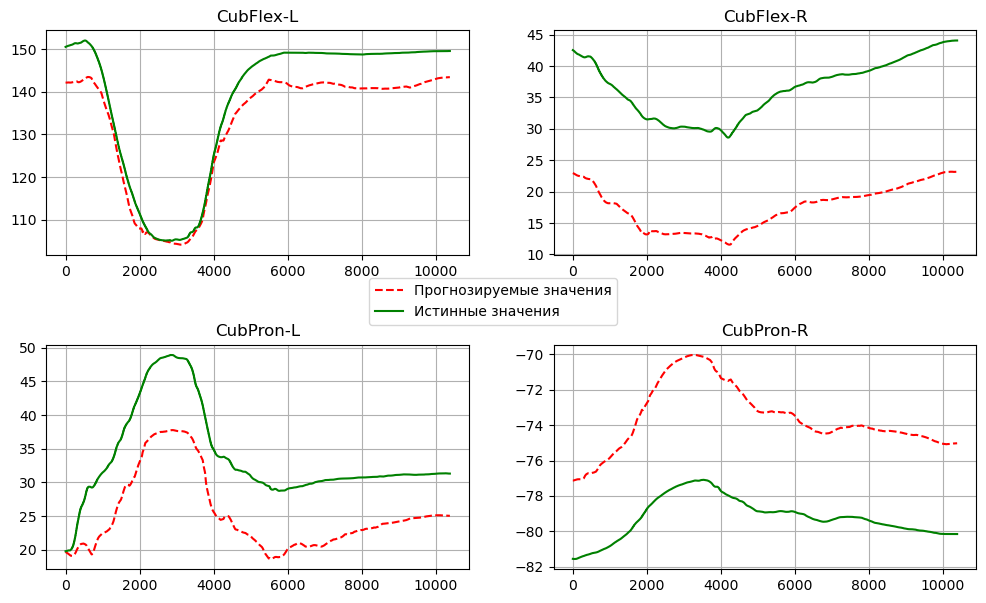

In [144]:
plot_predictions(postprocessed_predictions_5, y_test, 0, 11000)

In [145]:
def rmse(predictions, actuals):
    return np.sqrt(((predictions - actuals) ** 2).mean())

In [146]:
rmse(postprocessed_predictions_5, y_test)

11.264567546619828